<a href="https://colab.research.google.com/github/Mimohamed1998/wgan_tabular/blob/main/synthetic_data_generator__version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Process of testing advantage of synthetic data for regressional predicatios

1. Get a data set

2. Train a model and get the perfomance

3. Create synthetic data and mix with real data

4. Train the data with same model configuration is step 2 using synthetic + real data and test it with testing data of real data

5. Check if the results are improved

# Import Dependencies

In [1]:
!pip install -U scikit-learn
!pip install ydata-synthetic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 94.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.7/280.7 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━

In [2]:
from pmlb import fetch_data

from ydata_synthetic.synthesizers.regular import RegularSynthesizer
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

np.random.seed(1635848)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [6]:
def build_and_compile_model(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1)  # Assuming a regression task with a single output
    ])

    model.compile(optimizer='adam',
                  loss='mean_squared_error',  # You can change the loss function depending on your task
                  metrics=['mean_absolute_error', 'mean_squared_error'])  # Add more metrics as needed

    return model


In [7]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute MAE, RMSE, and MAPE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()


In [8]:
df = pd.read_csv('/content/sample_data/Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [9]:
# from google.colab import drive
# drive.mount('/content/drive')

# Preprocessing data

In [10]:
# Split the datetime into separate year, month, and day columns
# Convert the 'date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df = df.drop('Date' , axis = 1)
# Display the resulting DataFrame
df

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,12
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,19
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,26
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,5
...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,2012,9,28
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,5
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,12
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,19


In [11]:
df.dtypes

Store             int64
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
year              int32
month             int32
day               int32
dtype: object

## Splitting the dataframe

In [12]:
scaler = StandardScaler()

X = scaler.fit_transform(df.drop('Weekly_Sales',axis = 1))
y = df['Weekly_Sales'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
X_test.shape

(1287, 9)

In [14]:
df.Weekly_Sales.value_counts()

Weekly_Sales
1643690.90    1
446751.45     1
1332261.01    1
1366193.35    1
1384870.51    1
             ..
551799.63     1
573498.64     1
553901.97     1
533161.64     1
760281.43     1
Name: count, Length: 6435, dtype: int64

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_and_train_regression_model(X_train, y_train, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32):
    # Model Architecture
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(hidden_units[0], activation='relu'),
        layers.Dense(hidden_units[1], activation='relu'),
        layers.Dense(1)  # Regression output
    ])

    # Compile the Model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    # Training
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

    # Evaluate the Model
    test_loss, test_mae = model.evaluate(X_test, y_test)

    # Make predictions
    predictions = model.predict(X_test)

    return model, test_loss, test_mae, predictions

# Example usage:
# Replace X_train, y_train, X_test, y_test, and input_shape with your data and parameters.
# model, test_loss, test_mae, predictions = build_and_train_regression_model(X_train, y_train, X_test, y_test, input_shape)


Epoch 1/100
161/161 [==============================] - 3s 6ms/step - loss: 1421070565376.0000 - mean_absolute_error: 1049353.7500 - mean_squared_error: 1421070565376.0000 - val_loss: 1388418695168.0000 - val_mean_absolute_error: 1037280.2500 - val_mean_squared_error: 1388418695168.0000
Epoch 2/100
161/161 [==============================] - 1s 3ms/step - loss: 1420590055424.0000 - mean_absolute_error: 1049132.0000 - mean_squared_error: 1420590055424.0000 - val_loss: 1387439587328.0000 - val_mean_absolute_error: 1036824.8750 - val_mean_squared_error: 1387439587328.0000
Epoch 3/100
161/161 [==============================] - 1s 4ms/step - loss: 1418719395840.0000 - mean_absolute_error: 1048277.8125 - mean_squared_error: 1418719395840.0000 - val_loss: 1384621015040.0000 - val_mean_absolute_error: 1035525.1875 - val_mean_squared_error: 1384621015040.0000
Epoch 4/100
161/161 [==============================] - 1s 3ms/step - loss: 1414535184384.0000 - mean_absolute_error: 1046355.0625 - mean_sq

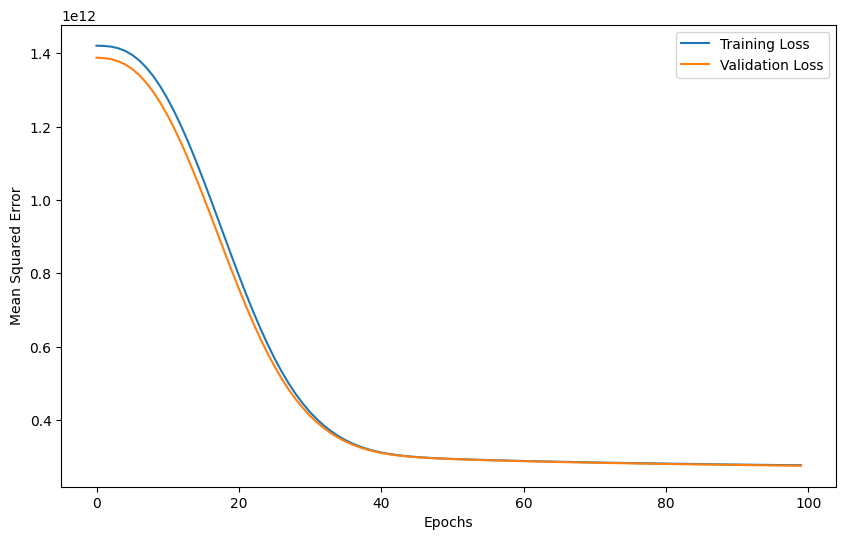

In [16]:
# Load your data and split it into features (X) and target (y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build and compile the model
model = build_and_compile_model(input_shape=X_train.shape[1])

# Train and evaluate the model
train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32)


In [17]:
# # Define the input shape based on the number of features
# input_shape = X_train.shape[1]

# # Call the function to build and train the regression model
# model, test_loss, test_mae, predictions = build_and_train_regression_model(
#     X_train, y_train, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32
# )

# # Print evaluation metrics
# print("Test Loss:", test_loss)
# print("Test MAE:", test_mae)

In [18]:
# # Print evaluation metrics
# print("Test Loss:", test_loss)
# print("Test MAE:", test_mae)

In [19]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,2010.965035,6.447552,15.678322
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,0.797019,3.238308,8.755780
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,2010.000000,1.000000,1.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,2010.000000,4.000000,8.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,2011.000000,6.000000,16.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,2012.000000,9.000000,23.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,2012.000000,12.000000,31.000000


In [55]:
num_cols = ['Weekly_Sales','Temperature','Fuel_Price','CPI']
cat_cols = ['Store','Holiday_Flag','Unemployment','year','month','day']

data = df

In [77]:
# Defining the training parameters
batch_size = 500
epochs = 50+1
learning_rate = 2e-4
beta_1 = 0.4
beta_2 = 0.9

ctgan_args = ModelParameters(batch_size=batch_size,
                             lr=learning_rate,
                             betas=(beta_1, beta_2))

train_args = TrainParameters(epochs=epochs)

In [78]:
synth = RegularSynthesizer(modelname='ctgan', model_parameters=ctgan_args)
synth.fit(data=data, train_arguments=train_args, num_cols=num_cols, cat_cols=cat_cols)


Epoch: 0 | critic_loss: 0.08641442656517029 | generator_loss: 3.0098538398742676
Epoch: 1 | critic_loss: 0.028736747801303864 | generator_loss: 2.8452816009521484
Epoch: 2 | critic_loss: 0.10732834786176682 | generator_loss: 2.6125845909118652
Epoch: 3 | critic_loss: 0.06199862062931061 | generator_loss: 2.5573551654815674
Epoch: 4 | critic_loss: 0.02935606986284256 | generator_loss: 2.475022315979004
Epoch: 5 | critic_loss: 0.0645429864525795 | generator_loss: 2.5391290187835693
Epoch: 6 | critic_loss: 0.08373419940471649 | generator_loss: 2.4678592681884766
Epoch: 7 | critic_loss: 0.03404811769723892 | generator_loss: 2.3753857612609863
Epoch: 8 | critic_loss: 0.1554012894630432 | generator_loss: 2.1996212005615234
Epoch: 9 | critic_loss: 0.14642050862312317 | generator_loss: 2.433887004852295
Epoch: 10 | critic_loss: 0.11216402053833008 | generator_loss: 2.2217557430267334
Epoch: 11 | critic_loss: 0.07927671074867249 | generator_loss: 2.206223964691162
Epoch: 12 | critic_loss: 0.080

In [87]:
# Defining the training parameters
batch_size = 500
epochs = 50+1
learning_rate = 1e-4
beta_1 = 0.3
beta_2 = 0.9

ctgan_args = ModelParameters(batch_size=batch_size,
                             lr=learning_rate,
                             betas=(beta_1, beta_2))

train_args = TrainParameters(epochs=epochs)

In [88]:
synth1 = RegularSynthesizer(modelname='ctgan', model_parameters=ctgan_args)
synth1.fit(data=data, train_arguments=train_args, num_cols=num_cols, cat_cols=cat_cols)


Epoch: 0 | critic_loss: 0.7664684057235718 | generator_loss: 3.0525455474853516
Epoch: 1 | critic_loss: 0.14497479796409607 | generator_loss: 3.0613441467285156
Epoch: 2 | critic_loss: 0.12068098783493042 | generator_loss: 2.8311357498168945
Epoch: 3 | critic_loss: 0.09255926311016083 | generator_loss: 2.9290623664855957
Epoch: 4 | critic_loss: 0.09835188090801239 | generator_loss: 2.660048007965088
Epoch: 5 | critic_loss: 0.10092519223690033 | generator_loss: 2.7031266689300537
Epoch: 6 | critic_loss: 0.0995725691318512 | generator_loss: 2.702521800994873
Epoch: 7 | critic_loss: 0.07160525768995285 | generator_loss: 2.8308863639831543
Epoch: 8 | critic_loss: 0.07903904467821121 | generator_loss: 2.562196969985962
Epoch: 9 | critic_loss: 0.0422205924987793 | generator_loss: 2.77026629447937
Epoch: 10 | critic_loss: 0.07392466068267822 | generator_loss: 2.681725025177002
Epoch: 11 | critic_loss: 0.08146432042121887 | generator_loss: 2.706986427307129
Epoch: 12 | critic_loss: 0.127621218

In [58]:
X_train.shape

(5148, 9)

In [59]:
X_train_sy.shape

(500, 9)

In [60]:
X_train_2.shape

(5648, 9)

In [61]:
X_train_sy.shape[1]

9

Epoch 1/100
224/224 [==============================] - 2s 5ms/step - loss: 1445004574720.0000 - mean_absolute_error: 1040374.8125 - mean_squared_error: 1445004574720.0000 - val_loss: 1388282380288.0000 - val_mean_absolute_error: 1037216.2500 - val_mean_squared_error: 1388282380288.0000
Epoch 2/100
224/224 [==============================] - 1s 3ms/step - loss: 1444083007488.0000 - mean_absolute_error: 1039943.5625 - mean_squared_error: 1444083007488.0000 - val_loss: 1386347233280.0000 - val_mean_absolute_error: 1036317.8125 - val_mean_squared_error: 1386347233280.0000
Epoch 3/100
224/224 [==============================] - 1s 3ms/step - loss: 1440700563456.0000 - mean_absolute_error: 1038375.8750 - mean_squared_error: 1440700563456.0000 - val_loss: 1381066604544.0000 - val_mean_absolute_error: 1033881.6875 - val_mean_squared_error: 1381066604544.0000
Epoch 4/100
224/224 [==============================] - 1s 3ms/step - loss: 1433375473664.0000 - mean_absolute_error: 1034977.8750 - mean_sq

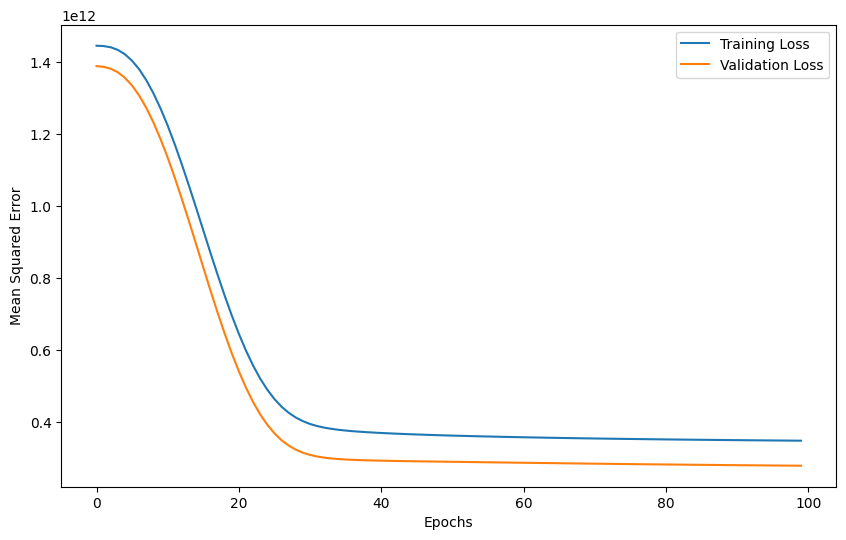

In [90]:
synth_data = synth1.sample(2000)
synth_data

scaler = StandardScaler()

X_train_sy = scaler.fit_transform(synth_data.drop('Weekly_Sales',axis = 1))
y_train_sy = synth_data['Weekly_Sales'].values


X_train_2 = np.concatenate((X_train, X_train_sy), axis=0)
X_train_2.shape

y_train_2 = np.concatenate((y_train, y_train_sy), axis=0)
y_train_2.shape



# Define the input shape based on the number of features
# input_shape = X_train_sy.shape[1]

# Load your data and split it into features (X) and target (y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build and compile the model
model = build_and_compile_model(input_shape=X_train_2.shape[1])

# Train and evaluate the model
train_and_evaluate_model(model, X_train_2, y_train_2, X_test, y_test, epochs=100, batch_size=32)


# # Call the function to build and train the regression model
# model, test_loss, test_mae, predictions = build_and_train_regression_model(
#     X_train_sy, y_train_sy, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32
# )

# # Print evaluation metrics
# print("Test Loss:", test_loss)
# print("Test MAE:", test_mae)

Epoch 1/100
474/474 [==============================] - 2s 2ms/step - loss: 1328390864896.0000 - mean_absolute_error: 973239.7500 - mean_squared_error: 1328390864896.0000 - val_loss: 1386789994496.0000 - val_mean_absolute_error: 1036516.8750 - val_mean_squared_error: 1386789994496.0000
Epoch 2/100
474/474 [==============================] - 1s 3ms/step - loss: 1323143004160.0000 - mean_absolute_error: 970596.8125 - mean_squared_error: 1323143004160.0000 - val_loss: 1375358550016.0000 - val_mean_absolute_error: 1031205.3750 - val_mean_squared_error: 1375358550016.0000
Epoch 3/100
474/474 [==============================] - 1s 3ms/step - loss: 1306060652544.0000 - mean_absolute_error: 962006.6875 - mean_squared_error: 1306060652544.0000 - val_loss: 1347735781376.0000 - val_mean_absolute_error: 1018336.7500 - val_mean_squared_error: 1347735781376.0000
Epoch 4/100
474/474 [==============================] - 2s 3ms/step - loss: 1273292914688.0000 - mean_absolute_error: 945338.3750 - mean_square

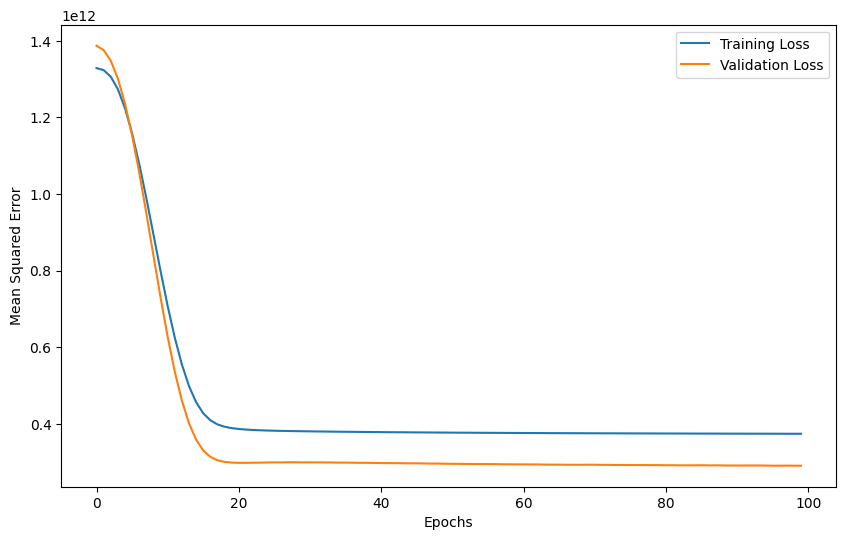

In [95]:
synth_data = synth.sample(10000)
synth_data

scaler = StandardScaler()

X_train_sy = scaler.fit_transform(synth_data.drop('Weekly_Sales',axis = 1))
y_train_sy = synth_data['Weekly_Sales'].values


X_train_2 = np.concatenate((X_train, X_train_sy), axis=0)
X_train_2.shape

y_train_2 = np.concatenate((y_train, y_train_sy), axis=0)
y_train_2.shape



# Define the input shape based on the number of features
# input_shape = X_train_sy.shape[1]

# Load your data and split it into features (X) and target (y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build and compile the model
model = build_and_compile_model(input_shape=X_train_2.shape[1])

# Train and evaluate the model
train_and_evaluate_model(model, X_train_2, y_train_2, X_test, y_test, epochs=100, batch_size=32)


# # Call the function to build and train the regression model
# model, test_loss, test_mae, predictions = build_and_train_regression_model(
#     X_train_sy, y_train_sy, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32
# )

# # Print evaluation metrics
# print("Test Loss:", test_loss)
# print("Test MAE:", test_mae)

Epoch 1/100
318/318 [==============================] - 2s 3ms/step - loss: 1344891518976.0000 - mean_absolute_error: 989608.1875 - mean_squared_error: 1344891518976.0000 - val_loss: 1387815108608.0000 - val_mean_absolute_error: 1036995.3125 - val_mean_squared_error: 1387815108608.0000
Epoch 2/100
318/318 [==============================] - 1s 2ms/step - loss: 1342444011520.0000 - mean_absolute_error: 988400.2500 - mean_squared_error: 1342444011520.0000 - val_loss: 1382386237440.0000 - val_mean_absolute_error: 1034463.8750 - val_mean_squared_error: 1382386237440.0000
Epoch 3/100
318/318 [==============================] - 1s 2ms/step - loss: 1333667299328.0000 - mean_absolute_error: 984067.7500 - mean_squared_error: 1333667299328.0000 - val_loss: 1368042766336.0000 - val_mean_absolute_error: 1027798.7500 - val_mean_squared_error: 1368042766336.0000
Epoch 4/100
318/318 [==============================] - 1s 2ms/step - loss: 1315468738560.0000 - mean_absolute_error: 975099.8750 - mean_square

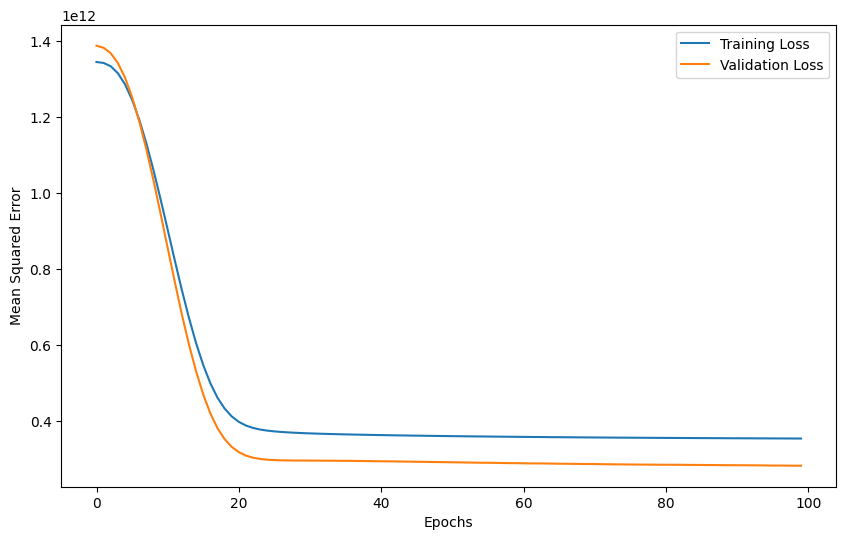

In [94]:
synth_data = synth.sample(5000)
synth_data

scaler = StandardScaler()

X_train_sy = scaler.fit_transform(synth_data.drop('Weekly_Sales',axis = 1))
y_train_sy = synth_data['Weekly_Sales'].values


X_train_2 = np.concatenate((X_train, X_train_sy), axis=0)
X_train_2.shape

y_train_2 = np.concatenate((y_train, y_train_sy), axis=0)
y_train_2.shape



# Define the input shape based on the number of features
# input_shape = X_train_sy.shape[1]

# Load your data and split it into features (X) and target (y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build and compile the model
model = build_and_compile_model(input_shape=X_train_2.shape[1])

# Train and evaluate the model
train_and_evaluate_model(model, X_train_2, y_train_2, X_test, y_test, epochs=100, batch_size=32)


# # Call the function to build and train the regression model
# model, test_loss, test_mae, predictions = build_and_train_regression_model(
#     X_train_sy, y_train_sy, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32
# )

# # Print evaluation metrics
# print("Test Loss:", test_loss)
# print("Test MAE:", test_mae)

Epoch 1/100
271/271 [==============================] - 2s 3ms/step - loss: 1355013947392.0000 - mean_absolute_error: 999044.6250 - mean_squared_error: 1355013947392.0000 - val_loss: 1388061130752.0000 - val_mean_absolute_error: 1037109.5000 - val_mean_squared_error: 1388061130752.0000
Epoch 2/100
271/271 [==============================] - 1s 2ms/step - loss: 1353385508864.0000 - mean_absolute_error: 998247.3750 - mean_squared_error: 1353385508864.0000 - val_loss: 1384497676288.0000 - val_mean_absolute_error: 1035439.6250 - val_mean_squared_error: 1384497676288.0000
Epoch 3/100
271/271 [==============================] - 1s 2ms/step - loss: 1347540221952.0000 - mean_absolute_error: 995393.0000 - mean_squared_error: 1347540221952.0000 - val_loss: 1375055249408.0000 - val_mean_absolute_error: 1031045.1875 - val_mean_squared_error: 1375055249408.0000
Epoch 4/100
271/271 [==============================] - 1s 2ms/step - loss: 1335340957696.0000 - mean_absolute_error: 989417.0000 - mean_square

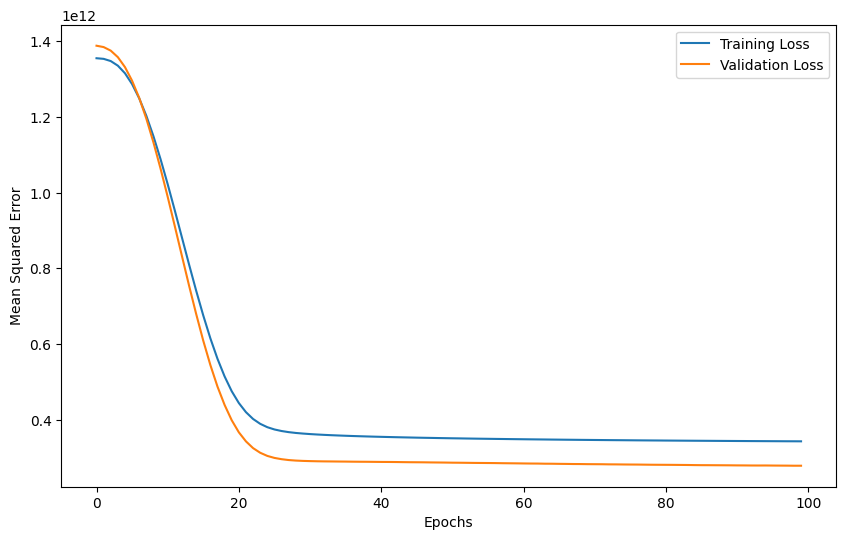

In [93]:
synth_data = synth.sample(3500)
synth_data

scaler = StandardScaler()

X_train_sy = scaler.fit_transform(synth_data.drop('Weekly_Sales',axis = 1))
y_train_sy = synth_data['Weekly_Sales'].values


X_train_2 = np.concatenate((X_train, X_train_sy), axis=0)
X_train_2.shape

y_train_2 = np.concatenate((y_train, y_train_sy), axis=0)
y_train_2.shape



# Define the input shape based on the number of features
# input_shape = X_train_sy.shape[1]

# Load your data and split it into features (X) and target (y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build and compile the model
model = build_and_compile_model(input_shape=X_train_2.shape[1])

# Train and evaluate the model
train_and_evaluate_model(model, X_train_2, y_train_2, X_test, y_test, epochs=100, batch_size=32)


# # Call the function to build and train the regression model
# model, test_loss, test_mae, predictions = build_and_train_regression_model(
#     X_train_sy, y_train_sy, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32
# )

# # Print evaluation metrics
# print("Test Loss:", test_loss)
# print("Test MAE:", test_mae)

Epoch 1/100
239/239 [==============================] - 2s 3ms/step - loss: 1364931510272.0000 - mean_absolute_error: 1010796.7500 - mean_squared_error: 1364931510272.0000 - val_loss: 1388077645824.0000 - val_mean_absolute_error: 1037121.0625 - val_mean_squared_error: 1388077645824.0000
Epoch 2/100
239/239 [==============================] - 1s 2ms/step - loss: 1363302547456.0000 - mean_absolute_error: 1010016.1250 - mean_squared_error: 1363302547456.0000 - val_loss: 1384584708096.0000 - val_mean_absolute_error: 1035509.1875 - val_mean_squared_error: 1384584708096.0000
Epoch 3/100
239/239 [==============================] - 1s 3ms/step - loss: 1357370884096.0000 - mean_absolute_error: 1007205.0000 - mean_squared_error: 1357370884096.0000 - val_loss: 1375159713792.0000 - val_mean_absolute_error: 1031176.6250 - val_mean_squared_error: 1375159713792.0000
Epoch 4/100
239/239 [==============================] - 1s 3ms/step - loss: 1344770801664.0000 - mean_absolute_error: 1001193.1875 - mean_sq

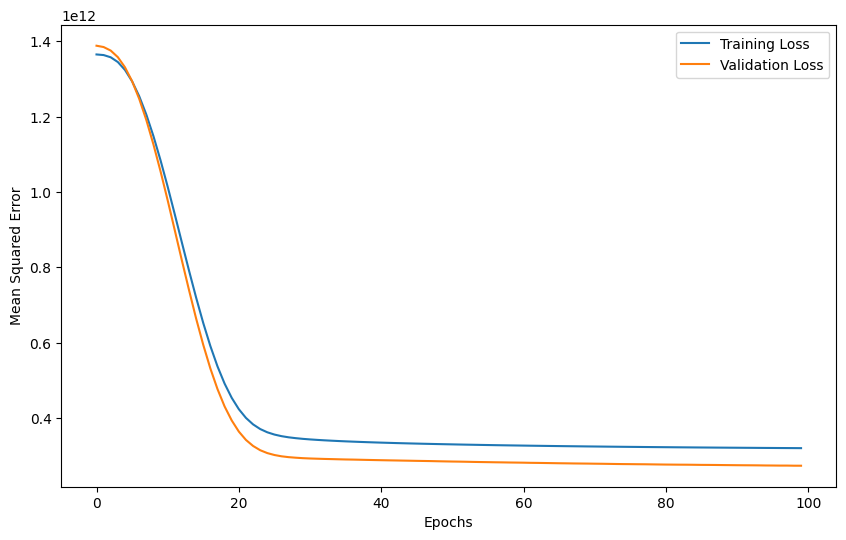

In [92]:
synth_data = synth.sample(2500)
synth_data

scaler = StandardScaler()

X_train_sy = scaler.fit_transform(synth_data.drop('Weekly_Sales',axis = 1))
y_train_sy = synth_data['Weekly_Sales'].values


X_train_2 = np.concatenate((X_train, X_train_sy), axis=0)
X_train_2.shape

y_train_2 = np.concatenate((y_train, y_train_sy), axis=0)
y_train_2.shape



# Define the input shape based on the number of features
# input_shape = X_train_sy.shape[1]

# Load your data and split it into features (X) and target (y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build and compile the model
model = build_and_compile_model(input_shape=X_train_2.shape[1])

# Train and evaluate the model
train_and_evaluate_model(model, X_train_2, y_train_2, X_test, y_test, epochs=100, batch_size=32)


# # Call the function to build and train the regression model
# model, test_loss, test_mae, predictions = build_and_train_regression_model(
#     X_train_sy, y_train_sy, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32
# )

# # Print evaluation metrics
# print("Test Loss:", test_loss)
# print("Test MAE:", test_mae)

Epoch 1/100
224/224 [==============================] - 3s 5ms/step - loss: 1359270641664.0000 - mean_absolute_error: 1008375.6875 - mean_squared_error: 1359270641664.0000 - val_loss: 1388319211520.0000 - val_mean_absolute_error: 1037234.2500 - val_mean_squared_error: 1388319211520.0000
Epoch 2/100
224/224 [==============================] - 1s 3ms/step - loss: 1358495875072.0000 - mean_absolute_error: 1008002.5625 - mean_squared_error: 1358495875072.0000 - val_loss: 1386610294784.0000 - val_mean_absolute_error: 1036444.9375 - val_mean_squared_error: 1386610294784.0000
Epoch 3/100
224/224 [==============================] - 1s 3ms/step - loss: 1355506778112.0000 - mean_absolute_error: 1006581.1250 - mean_squared_error: 1355506778112.0000 - val_loss: 1381761941504.0000 - val_mean_absolute_error: 1034217.8125 - val_mean_squared_error: 1381761941504.0000
Epoch 4/100
224/224 [==============================] - 1s 3ms/step - loss: 1348930502656.0000 - mean_absolute_error: 1003453.9375 - mean_sq

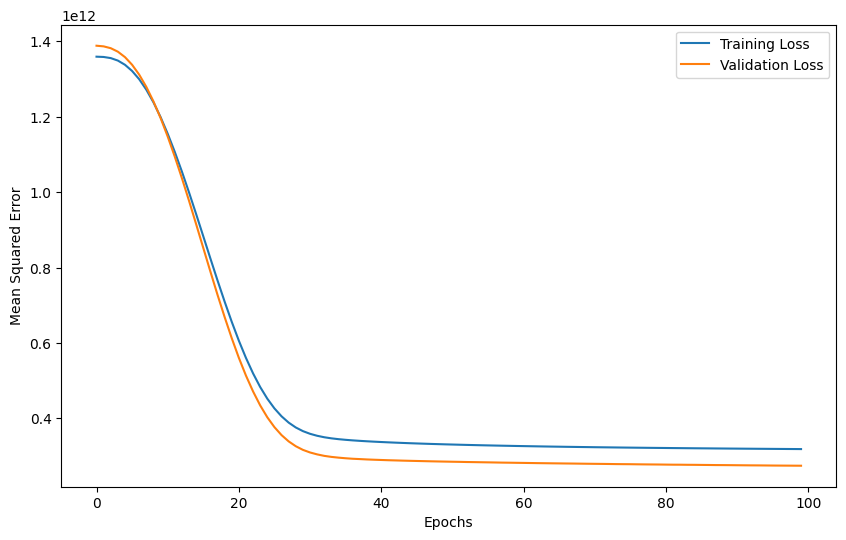

In [91]:
synth_data = synth.sample(2000)
synth_data

scaler = StandardScaler()

X_train_sy = scaler.fit_transform(synth_data.drop('Weekly_Sales',axis = 1))
y_train_sy = synth_data['Weekly_Sales'].values


X_train_2 = np.concatenate((X_train, X_train_sy), axis=0)
X_train_2.shape

y_train_2 = np.concatenate((y_train, y_train_sy), axis=0)
y_train_2.shape



# Define the input shape based on the number of features
# input_shape = X_train_sy.shape[1]

# Load your data and split it into features (X) and target (y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build and compile the model
model = build_and_compile_model(input_shape=X_train_2.shape[1])

# Train and evaluate the model
train_and_evaluate_model(model, X_train_2, y_train_2, X_test, y_test, epochs=100, batch_size=32)


# # Call the function to build and train the regression model
# model, test_loss, test_mae, predictions = build_and_train_regression_model(
#     X_train_sy, y_train_sy, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32
# )

# # Print evaluation metrics
# print("Test Loss:", test_loss)
# print("Test MAE:", test_mae)

Epoch 1/100
208/208 [==============================] - 1s 3ms/step - loss: 1368665882624.0000 - mean_absolute_error: 1019473.0000 - mean_squared_error: 1368665882624.0000 - val_loss: 1388357091328.0000 - val_mean_absolute_error: 1037251.7500 - val_mean_squared_error: 1388357091328.0000
Epoch 2/100
208/208 [==============================] - 0s 2ms/step - loss: 1367985225728.0000 - mean_absolute_error: 1019150.8125 - mean_squared_error: 1367985225728.0000 - val_loss: 1386896424960.0000 - val_mean_absolute_error: 1036577.3125 - val_mean_squared_error: 1386896424960.0000
Epoch 3/100
208/208 [==============================] - 0s 2ms/step - loss: 1365438234624.0000 - mean_absolute_error: 1017946.2500 - mean_squared_error: 1365438234624.0000 - val_loss: 1382887849984.0000 - val_mean_absolute_error: 1034739.0625 - val_mean_squared_error: 1382887849984.0000
Epoch 4/100
208/208 [==============================] - 0s 2ms/step - loss: 1359910928384.0000 - mean_absolute_error: 1015327.2500 - mean_sq

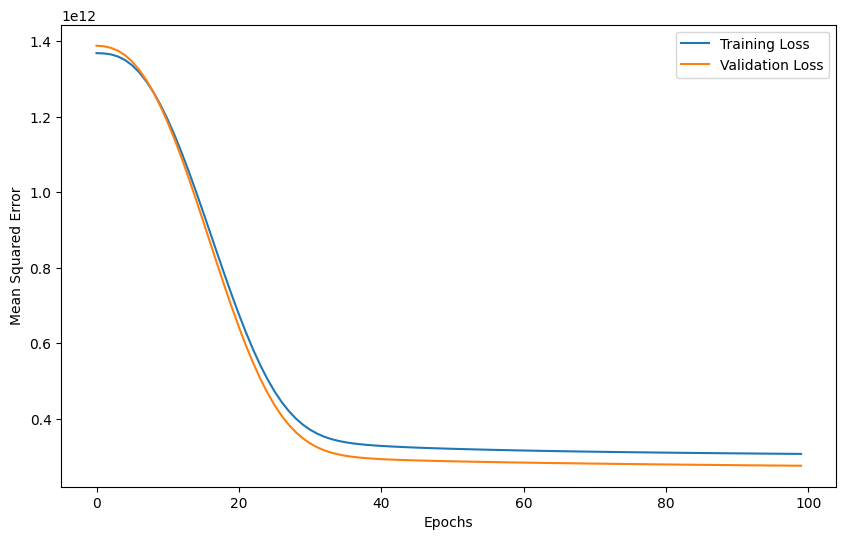

In [79]:
synth_data = synth.sample(1500)
synth_data

scaler = StandardScaler()

X_train_sy = scaler.fit_transform(synth_data.drop('Weekly_Sales',axis = 1))
y_train_sy = synth_data['Weekly_Sales'].values


X_train_2 = np.concatenate((X_train, X_train_sy), axis=0)
X_train_2.shape

y_train_2 = np.concatenate((y_train, y_train_sy), axis=0)
y_train_2.shape



# Define the input shape based on the number of features
# input_shape = X_train_sy.shape[1]

# Load your data and split it into features (X) and target (y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build and compile the model
model = build_and_compile_model(input_shape=X_train_2.shape[1])

# Train and evaluate the model
train_and_evaluate_model(model, X_train_2, y_train_2, X_test, y_test, epochs=100, batch_size=32)


# # Call the function to build and train the regression model
# model, test_loss, test_mae, predictions = build_and_train_regression_model(
#     X_train_sy, y_train_sy, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32
# )

# # Print evaluation metrics
# print("Test Loss:", test_loss)
# print("Test MAE:", test_mae)

Epoch 1/100
193/193 [==============================] - 1s 3ms/step - loss: 1395526336512.0000 - mean_absolute_error: 1033589.5000 - mean_squared_error: 1395526336512.0000 - val_loss: 1388326551552.0000 - val_mean_absolute_error: 1037236.6250 - val_mean_squared_error: 1388326551552.0000
Epoch 2/100
193/193 [==============================] - 0s 2ms/step - loss: 1394773852160.0000 - mean_absolute_error: 1033237.3125 - mean_squared_error: 1394773852160.0000 - val_loss: 1386744905728.0000 - val_mean_absolute_error: 1036502.4375 - val_mean_squared_error: 1386744905728.0000
Epoch 3/100
193/193 [==============================] - 0s 2ms/step - loss: 1391934701568.0000 - mean_absolute_error: 1031915.9375 - mean_squared_error: 1391934701568.0000 - val_loss: 1382271156224.0000 - val_mean_absolute_error: 1034444.0625 - val_mean_squared_error: 1382271156224.0000
Epoch 4/100
193/193 [==============================] - 1s 3ms/step - loss: 1385668935680.0000 - mean_absolute_error: 1029006.3125 - mean_sq

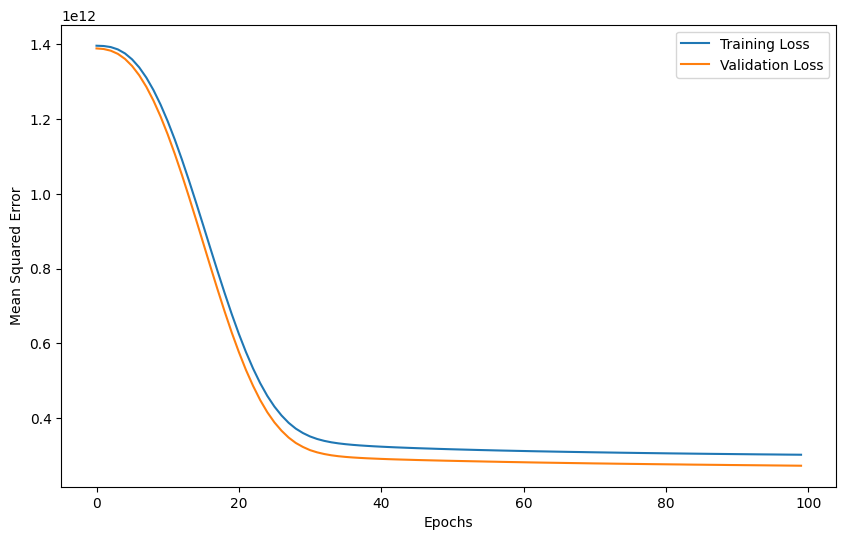

In [70]:
synth_data = synth.sample(1000)
synth_data

scaler = StandardScaler()

X_train_sy = scaler.fit_transform(synth_data.drop('Weekly_Sales',axis = 1))
y_train_sy = synth_data['Weekly_Sales'].values


X_train_2 = np.concatenate((X_train, X_train_sy), axis=0)
X_train_2.shape

y_train_2 = np.concatenate((y_train, y_train_sy), axis=0)
y_train_2.shape



# Define the input shape based on the number of features
# input_shape = X_train_sy.shape[1]

# Load your data and split it into features (X) and target (y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Build and compile the model
model = build_and_compile_model(input_shape=X_train_2.shape[1])

# Train and evaluate the model
train_and_evaluate_model(model, X_train_2, y_train_2, X_test, y_test, epochs=100, batch_size=32)


# # Call the function to build and train the regression model
# model, test_loss, test_mae, predictions = build_and_train_regression_model(
#     X_train_sy, y_train_sy, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32
# )

# # Print evaluation metrics
# print("Test Loss:", test_loss)
# print("Test MAE:", test_mae)

MAE: 430128.60

RMSE: 526338.91

MAPE: 68.89%

In [63]:
# synth_data = synth.sample(1000)
# synth_data

# scaler = StandardScaler()

# X_train_sy = scaler.fit_transform(synth_data.drop('Weekly_Sales',axis = 1))
# y_train_sy = synth_data['Weekly_Sales'].values


# X_train_2 = np.concatenate((X_train, X_train_sy), axis=0)
# X_train_2.shape

# y_train_2 = np.concatenate((y_train, y_train_sy), axis=0)
# y_train_2.shape



# # Define the input shape based on the number of features
# # input_shape = X_train_sy.shape[1]

# # Load your data and split it into features (X) and target (y)
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# # Build and compile the model
# model = build_and_compile_model(input_shape=X_train_sy.shape[1])

# # Train and evaluate the model
# train_and_evaluate_model(model, X_train_2, y_train_2, X_test, y_test, epochs=100, batch_size=32)


# # # Call the function to build and train the regression model
# # model, test_loss, test_mae, predictions = build_and_train_regression_model(
# #     X_train_sy, y_train_sy, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32
# # )

# # # Print evaluation metrics
# # print("Test Loss:", test_loss)
# # print("Test MAE:", test_mae)


In [64]:
# synth_data = synth.sample(500)
# synth_data

# scaler = StandardScaler()

# X_train_sy = scaler.fit_transform(synth_data.drop('Weekly_Sales',axis = 1))
# y_train_sy = synth_data['Weekly_Sales'].values


# X_train_2 = np.concatenate((X_train, X_train_sy), axis=0)
# X_train_2.shape

# y_train_2 = np.concatenate((y_train, y_train_sy), axis=0)
# y_train_2.shape



# # Define the input shape based on the number of features
# # input_shape = X_train_sy.shape[1]

# # Load your data and split it into features (X) and target (y)
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# # Build and compile the model
# model = build_and_compile_model(input_shape=X_train_sy.shape[1])

# # Train and evaluate the model
# train_and_evaluate_model(model, X_train_2, y_train_2, X_test, y_test, epochs=100, batch_size=32)


# # # Call the function to build and train the regression model
# # model, test_loss, test_mae, predictions = build_and_train_regression_model(
# #     X_train_sy, y_train_sy, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32
# # )

# # # Print evaluation metrics
# # print("Test Loss:", test_loss)
# # print("Test MAE:", test_mae)

In [65]:
# synth_data = synth.sample(12000)
# synth_data

# scaler = StandardScaler()

# X_train_sy = scaler.fit_transform(synth_data.drop('Weekly_Sales',axis = 1))
# y_train_sy = synth_data['Weekly_Sales'].values


# X_train_2 = np.concatenate((X_train, X_train_sy), axis=0)
# X_train_2.shape

# y_train_2 = np.concatenate((y_train, y_train_sy), axis=0)
# y_train_2.shape



# # Define the input shape based on the number of features
# # input_shape = X_train_sy.shape[1]

# # Load your data and split it into features (X) and target (y)
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# # Build and compile the model
# model = build_and_compile_model(input_shape=X_train_sy.shape[1])

# # Train and evaluate the model
# train_and_evaluate_model(model, X_train_2, y_train_2, X_test, y_test, epochs=100, batch_size=32)


# # # Call the function to build and train the regression model
# # model, test_loss, test_mae, predictions = build_and_train_regression_model(
# #     X_train_sy, y_train_sy, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32
# # )

# # # Print evaluation metrics
# # print("Test Loss:", test_loss)
# # print("Test MAE:", test_mae)

In [66]:
# synth_data = synth.sample(6000)
# synth_data

# scaler = StandardScaler()

# X_train_sy = scaler.fit_transform(synth_data.drop('Weekly_Sales',axis = 1))
# y_train_sy = synth_data['Weekly_Sales'].values


# X_train_2 = np.concatenate((X_train, X_train_sy), axis=0)
# X_train_2.shape

# y_train_2 = np.concatenate((y_train, y_train_sy), axis=0)
# y_train_2.shape



# # Define the input shape based on the number of features
# # input_shape = X_train_sy.shape[1]

# # Load your data and split it into features (X) and target (y)
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# # Build and compile the model
# model = build_and_compile_model(input_shape=X_train_sy.shape[1])

# # Train and evaluate the model
# train_and_evaluate_model(model, X_train_2, y_train_2, X_test, y_test, epochs=100, batch_size=32)


# # # Call the function to build and train the regression model
# # model, test_loss, test_mae, predictions = build_and_train_regression_model(
# #     X_train_sy, y_train_sy, X_test, y_test, input_shape, hidden_units=(64, 32), epochs=50, batch_size=32
# # )

# # # Print evaluation metrics
# # print("Test Loss:", test_loss)
# # print("Test MAE:", test_mae)